In [40]:
import astropy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import astropy.table as tb
import astropy.units as u 
from astropy.stats import sigma_clip
import gc
from scipy.stats.mstats import theilslopes
import cProfile
import re
import time
import corner
from statistics import median, mean

In [2]:
fin = tb.Table.read('DES0135-0416_final.fits')

In [3]:
def outlier_rejection(fin):
    # list of match_id's 
    start = time.clock()
    #cols = fin.colnames
    fin = fin.group_by('MATCH_ID')
    col = tb.Column([0]*len(fin), name='OUT_FLAG')
    fin.add_column(col)
    keys = fin.groups.keys[0:1000]
    #t = np.array([], dtype=tb.Row)
    # Remove flagged observations
    out2 = [i for i,j in enumerate(fin) if fin['IMAFLAGS_ISO'][i] != 0]
    fin['OUT_FLAG'][out2] = 1
    # remove COADD from values
    out1 = [i for i,j in enumerate(fin) if fin['VERSION'][i] == 'COADD']
    fin['OUT_FLAG'][out1] = 2
    for match_id in keys['MATCH_ID']:
        pec = np.where(fin['MATCH_ID'] == match_id)
        pec2 = np.where(fin[pec]['OUT_FLAG'] == 0)
        pec3 = fin[pec2]
        #pec3 = [i for i in pec['OUT_FLAG'][i] == 0]
        # minimum number of observation needed for fit - 3,4?
        if len(pec3['MJD_OBS']) < 4:
            continue
        else:
            # RA over time
            ts2 = theilslopes(pec3['NEW_RA'], pec3['MJD_OBS'])
            # Dec over time
            ts3 = theilslopes(pec3['NEW_DEC'], pec3['MJD_OBS'])
            least_dist_ra = []
            least_dist_dec = []
            # calculate absolute distance from each obs to fit line
            for iden in pec3:
                d = np.abs(ts2[1] + ts2[0]*iden['MJD_OBS'] - iden['NEW_RA'])/np.sqrt(1 + ts2[0]**2)
                least_dist_ra.append(d)
                d2 = np.abs(ts3[1] + ts3[0]*iden['MJD_OBS'] - iden['NEW_DEC'])/np.sqrt(1 + ts3[0]**2)
                least_dist_dec.append(d)
            # reject outliers based on absolute distance from theil slope fit line 3 sigma
            least_dist_ra = sigma_clip(least_dist_ra, sigma = 3)
            least_dist_dec = sigma_clip(least_dist_dec, sigma = 3)
            idx = [i for i in range(len(pec3)) if least_dist_ra.mask[i] == True]
            idx2 = [i for i in range(len(pec3)) if least_dist_dec.mask[i] == True]
            # intersection of invalid obs in RA and Dec
            idx3 = list(set(idx).intersection(set(idx2)))
            pec3['OUT_FLAG'][idx3] = 1
            if len(np.where(pec3['OUT_FLAG'] == 0)) < 3:
                pec3['OUT_FLAG'][:] = 1
    """
    if t.size != 0:
        t = tb.Table(np.vstack(t))
        for i, name in enumerate(t.colnames):
            t.rename_column(t.colnames[i],cols[i])
    else:
        t = tb.Table()
    """
    print(time.clock() - start)
    return fin[np.where(fin['OUT_FLAG'] != 1)]

In [ ]:
out = outlier_rejection(fin)

In [ ]:
# 323040
out

In [ ]:
cProfile.run('outlier_rejection(fin)')

In [3]:
t = tb.Table.read('zone029/DES0135-0416_proper_n.fits')
t2 = tb.Table.read('zone029/DES0135-0416_proper.fits')

In [6]:
fil = t[np.where(t['VEL'] > 0.1)]

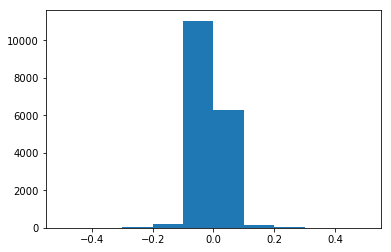

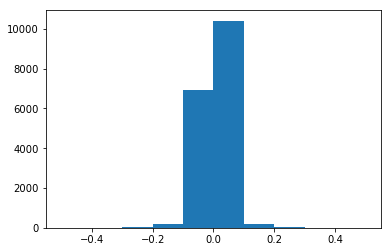

In [6]:
plt.hist(t['MU_RA'], range = (-0.5, 0.5))
plt.show()
plt.hist(t['MU_DEC'], range = (-0.5, 0.5))
plt.show()

MATCH_ID   COADD_ID    SPREAD_MODEL  ...      VEL         SIGMA_VEL   
-------- ----------- --------------- ... -------------- --------------
 20050.0 233010237.0 0.0151304006577 ... 0.262340572714 0.035882110836
MATCH_ID   COADD_ID    SPREAD_MODEL   ...      VEL          SIGMA_VEL   
-------- ----------- ---------------- ... -------------- ---------------
 20050.0 233025954.0 0.00870365276933 ... 0.172916742607  0.026185407092
 20050.0 233025960.0  0.0121062453836 ... 0.172916695928 0.0261854070961


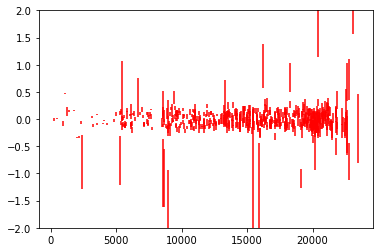

In [8]:
odd = []
for match_id in fil['MATCH_ID']:
    r1 = fil[np.where(fil['MATCH_ID'] == match_id)]
    r2 = t2[np.where(t2['MATCH_ID'] == match_id)]
    if match_id in t2['MATCH_ID']:
        if len(r1) != len(r2):
            print(r1)
            print(r2)
        plt.errorbar(match_id,r1[0]['MU_RA'] - r2[0]['MU_RA'],yerr = np.sqrt(r1[0]['MU_RA_ERR']) + np.sqrt(r2[0]['MU_RA_ERR']) ,c='r')
        if np.abs(r1[0]['MU_RA'] - r2[0]['MU_RA']) > 0.5:
            odd.append(match_id)
plt.ylim(-2, 2)
plt.show()

In [8]:
t[np.where(t['MATCH_ID'] == odd[1])]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5252.0,233005284.0,0.007921050302684307,0.007612800691276789,1.2319452180271822,23.471667380769194,0.5083479161058775,-3.9741958136769426,0.5072763772730001,-0.7271038097935307,0.1855646197130915,0.7744168376654593,0.18523291176616974,-0.00018399669267153064,0.3067758229187113,-0.0005917924551406087,-0.0003327953018892831,-0.00033238065475401914,0.3061803031420884,23.47196,-3.9744509999999997,3.0,6.080673205733946,1.0610662352516316,0.4307801406448622


In [11]:
t2[np.where(t2['MATCH_ID'] == odd[1])]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5252.0,233005421.0,0.01048977393656969,0.004305751994252205,3.0208511344745967,23.674560543407885,0.05603193242027595,-3.9773524073378894,0.0558866140448057,0.03605766816714595,0.0004455170325990535,-0.021878443854519983,0.0004444456632378775,2.9685098026332586e-08,-0.004970290208705268,-1.470860911170328e-05,5.182078614010775e-07,5.172903265304159e-07,-0.0049578799120187445,23.6746,-3.9773769999999997,6.0,3.995539696497601,0.04210185830575792,0.021099795243082524


In [12]:
odd

[2389.0,
 5252.0,
 5440.0,
 8558.0,
 8621.0,
 8954.0,
 15478.0,
 15877.0,
 16245.0,
 18291.0,
 19152.0,
 20400.0,
 21801.0,
 22656.0,
 22773.0,
 22825.0,
 23084.0]

In [13]:
fin[np.where(fin['MATCH_ID'] == odd[1])]

RA,DEC,ERRAWIN_WORLD,XWIN_IMAGE,YWIN_IMAGE,SPREAD_MODEL,SPREADERR_MODEL,FLUX_AUTO,FLUXERR_AUTO,EXPNUM,IMAFLAGS_ISO,ERRBWIN_WORLD,A_IMAGE,ERRA_IMAGE,B_IMAGE,ERRB_IMAGE,THETA_IMAGE,ERRTHETAWIN_J2000,CHI2_MODEL,CHI2_PSF,CCDNUM,BAND,MJD_OBS,EXPTIME,MAG_ZERO,VERSION,X_GNOM,Y_GNOM,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y,COADD_OBJECT_ID,ALPHAWIN_J2000,DELTAWIN_J2000,FLUX_AUTO_G,FLUX_AUTO_R,FLUX_AUTO_I,FLUX_AUTO_Z,FLUX_AUTO_Y,MAGERR_AUTO_G,MAGERR_AUTO_R,MAGERR_AUTO_I,MAGERR_AUTO_Z,MAGERR_AUTO_Y,FLUXERR_AUTO_G,FLUXERR_AUTO_R,FLUXERR_AUTO_I,FLUXERR_AUTO_Y,SPREAD_MODEL_I,SPREADERR_MODEL_I,MATCH_ID,COLOR,NEW_RA,NEW_DEC
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,bytes5,float64,float64,float64,bytes30,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
23.47196,-3.9744509999999997,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,999999,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,16959,N/A,1e+20,1e+20,1e+20,COADD,-2.767021946581117,1.0014672618674596,23.517152786254883,24.588363647460938,23.52617835998535,23.800350189208984,22.393634796142578,233005284,23.471959727801,-3.974450606806,391.86749267578125,146.1015625,388.62310791015625,301.89764404296875,1102.9249267578125,0.1136191189289093,0.44291195273399353,0.3311588168144226,0.6179584264755249,0.5125809907913208,40.997825622558594,59.58575439453125,118.50457763671875,520.5693969726562,0.007921050302684307,0.007612800691276789,5252.0,-0.00902557373046875,23.471959727801,-3.974450606806
23.471942,-3.974487,1.9376500858925283e-05,326.15350341796875,3159.193359375,-0.0018180799670517445,0.006535510066896677,962.3699951171875,283.77099609375,258864,0,1.9365899788681418e-05,0.7620440125465393,-9999.0,0.5662189722061157,-9999.0,41.589599609375,-27.13249969482422,-9999.0,2.188760006571755e-10,20,r,56627.17665996,90.0,31.669761657714844,y4a1_v1.5,-2.7670037272030448,1.001388610741702,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,5252.0,-0.00902557373046875,23.471977615258222,-3.974529202719092
23.471994,-3.9745169999999996,2.2518299374496564e-05,405.4988708496094,3200.954833984375,-0.00030631799018010497,0.0039467900060117245,2091.429931640625,299.53900146484375,247172,0,2.243410017399583e-05,1.4357999563217163,-9999.0,1.1477500200271606,-9999.0,23.965200424194336,-4.2215399742126465,-9999.0,4.1713499321360814e-10,20,g,56592.10406734,90.0,31.490934371948242,y4a1_v1.5,-2.766952377971133,1.001344612364793,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,5252.0,-0.00902557373046875,23.472028775556264,-3.974573307948155
23.47198,-3.974544,3.24436005030293e-05,1660.5732421875,4040.272705078125,-0.0060394201427698135,0.0054158600978553295,1349.43994140625,238.15899658203125,233215,0,3.216179902665317e-05,1.416200041770935,-9999.0,0.6149299740791321,-9999.0,-53.37329864501953,44.034000396728516,-9999.0,1.301989960289518e-09,43,g,56547.3853151,90.0,31.478530883789062,y4a1_v1.5,-2.7669703290330365,1.0013499595818243,1e+20,1e+20,1e+20,1e+20,1e+20,999999,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,1e+20,5252.0,-0.00902557373046875,23.472010848381522,-3.974567908554959


In [14]:
fil

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
210.0,234537050.0,0.016648463904857635,0.0040456089191138744,1.662675901108206,24.136019687264806,0.0006432603694289129,-3.9071884018861986,0.0006440753915032925,0.06148555374035728,0.00033344410443575536,-0.0888146228132083,0.0003343011163488987,-6.791177458313723e-08,-0.0001256010884741413,2.8485703179511606e-08,3.011074891115975e-07,3.0104089208321856e-07,-0.00012712271447812724,24.136017,-3.90717,11.0,34.926605315473466,0.10793960120787564,0.018278069895822962
474.0,233003411.0,0.013168940320611,0.0008796198526397347,7.341904043492772,23.604136900387687,0.00011127975650448479,-3.946903731090725,0.00011049225356791078,-0.0006172726198371218,0.00011235837297340007,0.16221631585414747,0.00011317582124418098,-2.9697735046531747e-07,-6.370479745848634e-05,5.991727429127685e-07,-2.024413287570911e-07,-2.161775185259581e-07,-6.232504707779436e-05,23.604091,-3.9468159999999997,12.0,232.50699506542264,0.16221748472227226,0.010638517951931435
884.0,233007035.0,0.007161678280681372,0.007679985836148262,1.5118449585164706,23.661260245030437,0.00171240815703974,-4.013181208242209,0.0017156061248801376,-0.09775943651107766,0.0009571173348244782,-0.06256072098475476,0.0009621593869166463,-1.2913951558386203e-08,0.0008947653673374802,3.349034604822619e-06,2.044209009236325e-06,2.037689040109291e-06,0.0008976340827627335,23.661226,-4.013116,5.0,14.053037189316868,0.11586173951410045,0.030960872757632527
1044.0,233004495.0,0.004922813270241022,0.00017896776262205094,1.190845885284636,23.892483791354596,2.769380486039409e-06,-3.955872750009222,2.436780546060191e-06,0.46573818006148787,1.918750708873362e-06,-0.18533876911317473,1.747390200294257e-06,1.9652586364892886e-07,-6.009885482969442e-07,2.926964556969159e-07,1.4216188442598227e-07,1.3469917359025472e-07,-5.441010832971922e-07,23.892350999999998,-3.955793,27.0,144490.4574081953,0.5002301363018042,0.0013266360179018562
1240.0,233006943.0,0.01631239429116249,0.004200387746095657,0.5109680553275809,23.991374808335724,0.011648191125577094,-4.01077109803521,0.01164559030417079,0.13493395003131609,0.006392552227123334,-0.08876496789982648,0.0063967108373306466,-5.2186832482096575e-06,0.007892324815583123,-3.3005752252425416e-06,-3.808146830730247e-06,-3.811708381092862e-06,0.007894234777966466,23.991291,-4.010693,5.0,4.076891537703515,0.1612368487530117,0.07999130894455732
1411.0,233010088.0,0.03922218456864357,0.0007525320397689939,69.98191657000875,23.93940366656929,3.979468320079215e-06,-4.087597871186148,8.139537631726058e-06,0.14163834832250402,2.0641373795118036e-06,0.06575073213360359,4.066586116436599e-06,1.275089842954443e-06,1.2771685258291022e-06,1.4984035765888933e-06,6.079852663449118e-07,9.265733445772216e-07,4.113433324830156e-06,23.939384,-4.087600999999999,10.0,9863.231553524009,0.15582890326748308,0.0018428766394739827
1569.0,233015070.0,0.001054747961461544,0.00032203621231019497,0.6632215201572184,23.53357487038488,3.1290566973091426e-06,-4.1951143031110645,2.953968740958049e-06,0.13911290827407571,2.606432118795103e-06,0.07080505729537068,2.43304856490694e-06,8.22062053644695e-08,-7.438847595782425e-07,1.8022277775765977e-07,-1.891108851807404e-08,-2.457357076160882e-08,-4.999907338756512e-07,23.533511999999998,-4.195067,37.0,9239.864279375299,0.15576327419547817,0.0016239379009993784
1588.0,233013761.0,-0.0013050073757767677,2.2243664716370404e-05,1.3055377723961483,23.51223780482527,2.0582684729825043e-06,-4.168523703985598,1.8155701395828207e-06,0.03310055430811596,1.263339889287839e-06,-0.10126371866639486,1.0990489765777031e-06,1.545407829495

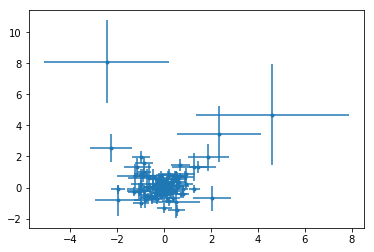

In [15]:
plt.errorbar(t['MU_RA'], t['MU_DEC'],xerr=np.sqrt(t['MU_RA_ERR']),yerr=np.sqrt(t['MU_DEC_ERR']),fmt= '.')
#plt.xlim(-0.25, 0.25)
#plt.ylim(-0.25, 0.25)
plt.show()

In [13]:
# Does not work
#z = np.diag(t['VEL'])
#plt.contour(t['MU_RA'], t['MU_DEC'], z)
#plt.xlim(-0.25, 0.25)
#plt.ylim(-0.25, 0.25)
#plt.show()

In [11]:
import glob
filenames = glob.glob('zone029/*proper_n.fits')
tiles = []
list.sort(filenames)
for name in filenames:
    tiles.append(tb.Table.read(name))

In [12]:
filenames2 = glob.glob('zone055/*proper_n.fits')
tiles2 = []
list.sort(filenames2)
for name in filenames2:
    tiles2.append(tb.Table.read(name))

In [102]:
def PM_density_plots(tile,xmin = 0,xmax = 0,ymin = 0,ymax = 0,lim = 0.05):
    ''' 2D histogram of proper motions distribution in tile '''
    pmra = []
    pmdec = []
    for row in tile:
        if row['SPREAD_MODEL'] < 0.004:
            pmra.append(row['MU_RA'])
            pmdec.append(row['MU_DEC'])
    #pmra, pmdec = gaussian_filter((pmra, pmdec), (1, 1))
    #plt.plot(pmra, pmdec, '.', alpha = 0.5)
    plt.hist2d(pmra,pmdec,range=[[-lim, lim],[-lim,lim]], norm = colors.LogNorm(vmin = 1, vmax = 10000))
    if xmin != 0:
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
    #else:
        #plt.xlim(-lim, lim)
        #plt.ylim(-lim, lim)
    plt.title('Proper motions distribution')
    plt.xlabel('MU RA (as/yr)')
    plt.ylabel('MU DEC (as/yr)')
    plt.colorbar()
    plt.show()

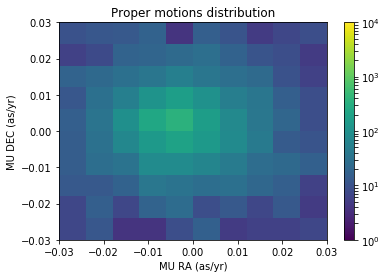

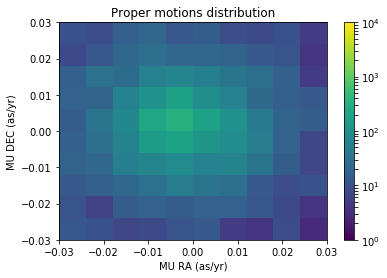

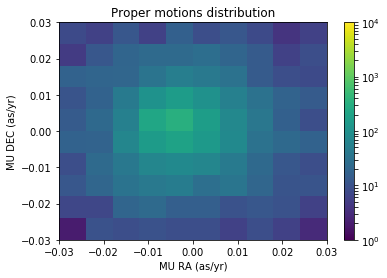

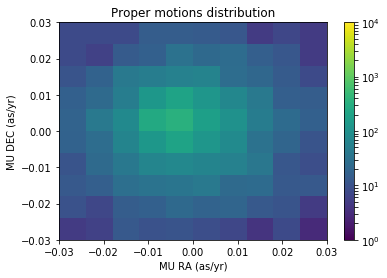

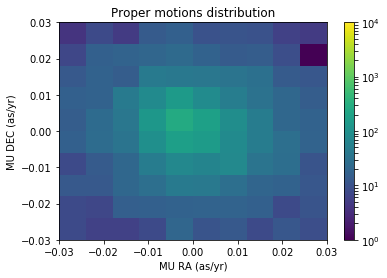

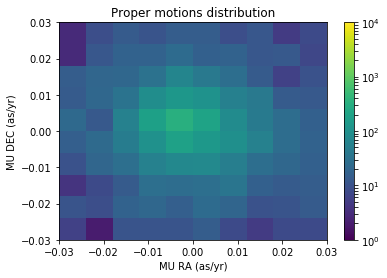

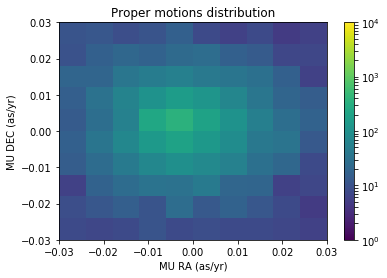

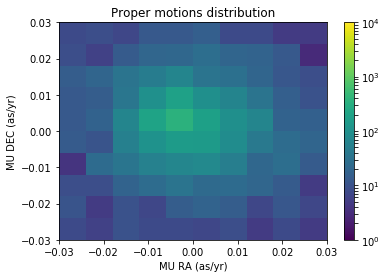

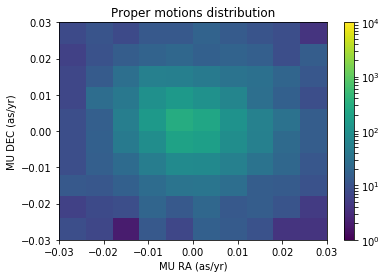

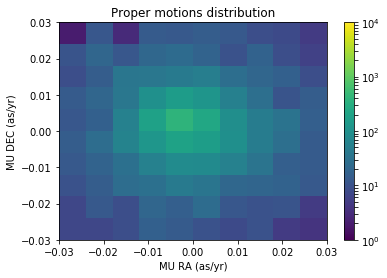

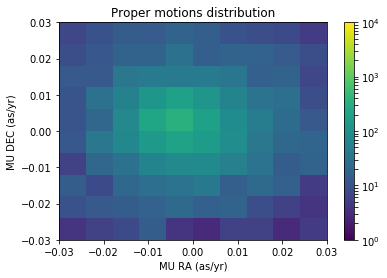

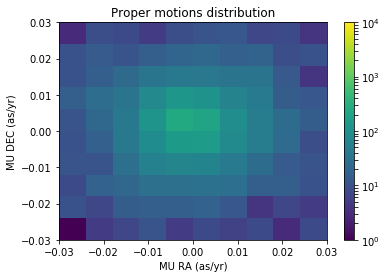

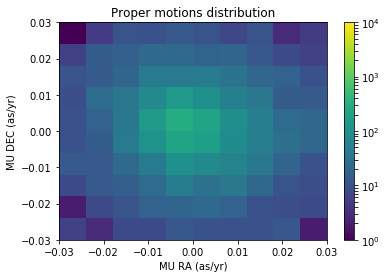

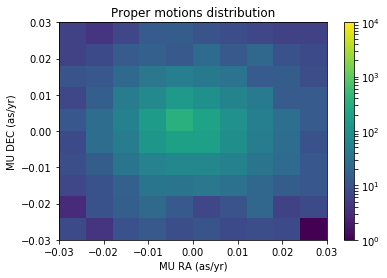

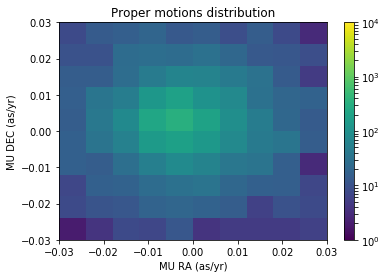

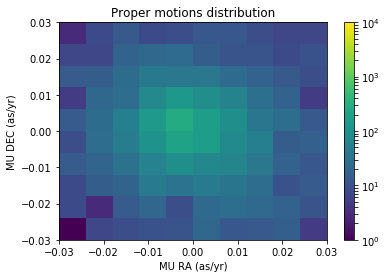

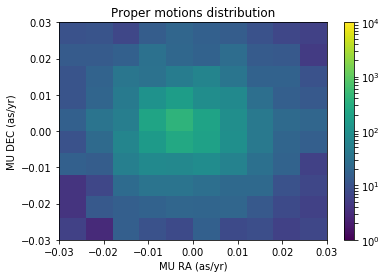

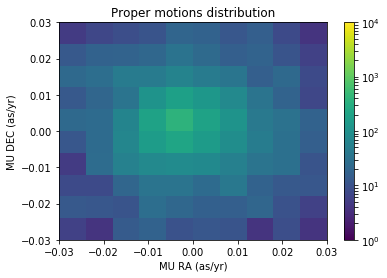

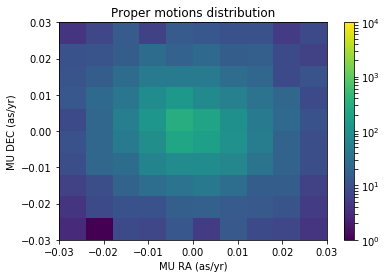

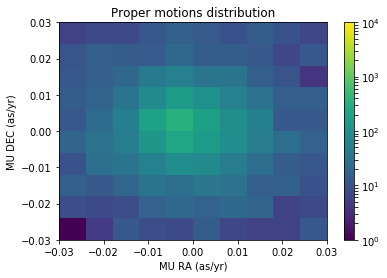

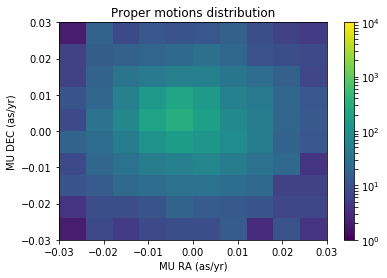

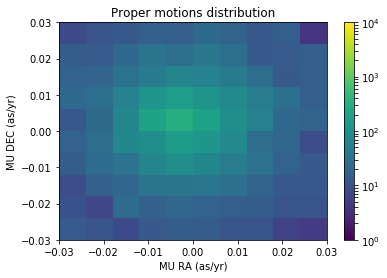

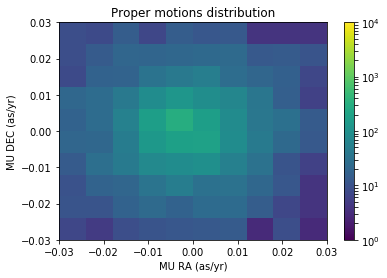

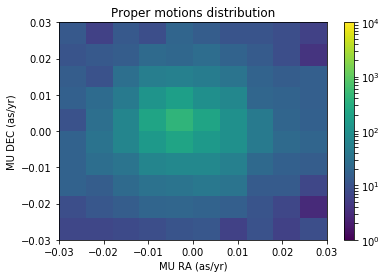

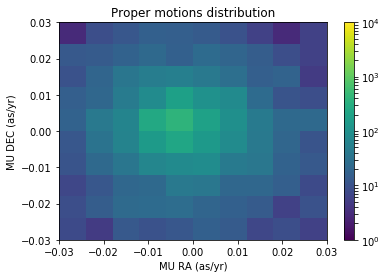

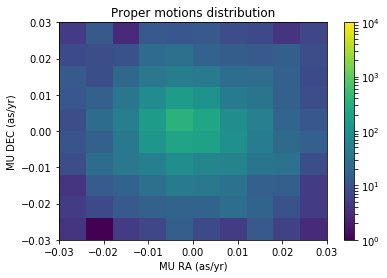

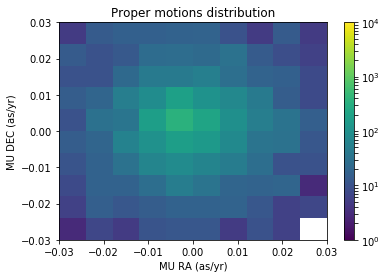

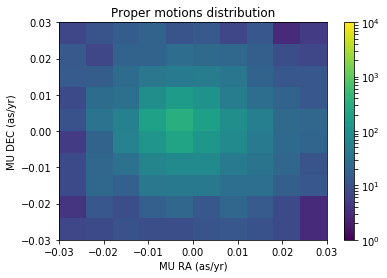

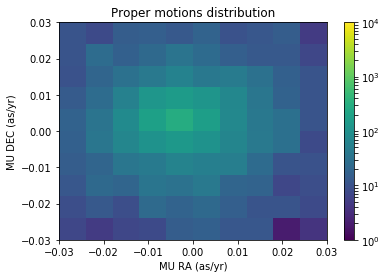

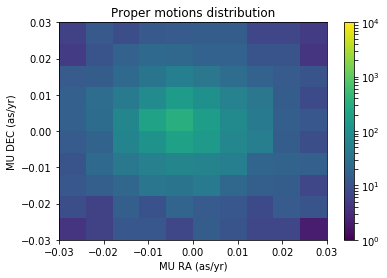

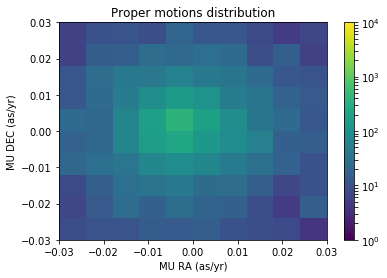

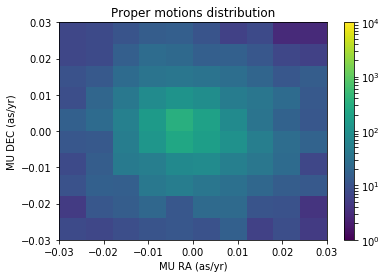

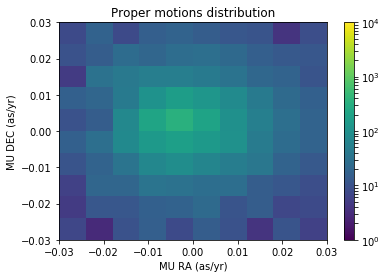

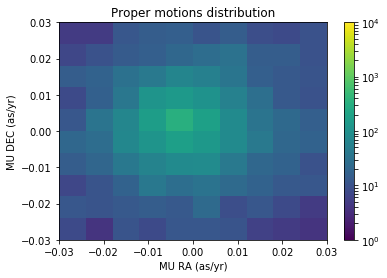

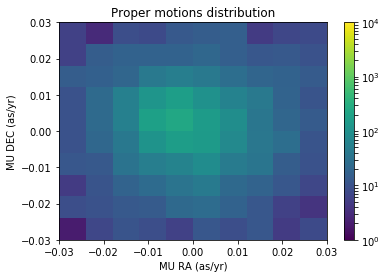

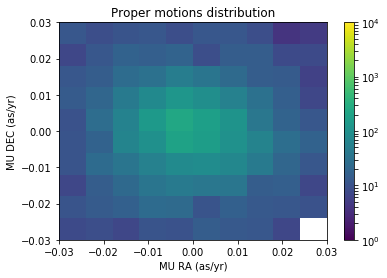

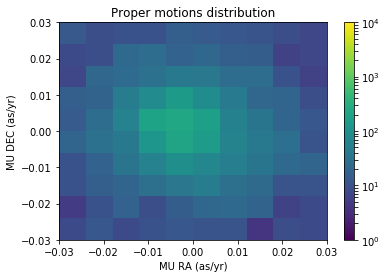

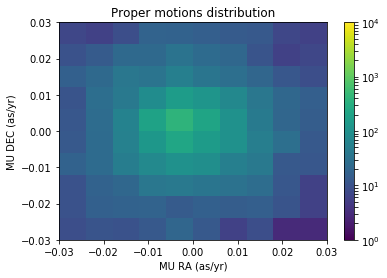

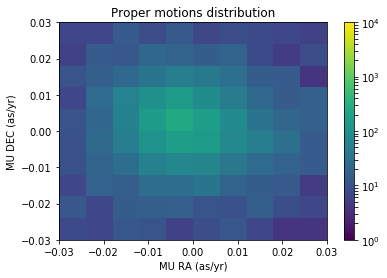

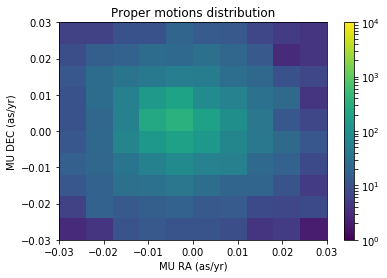

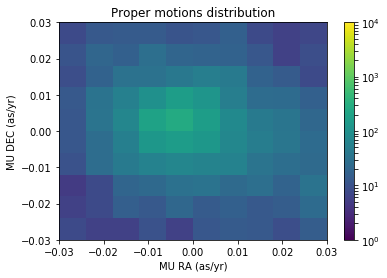

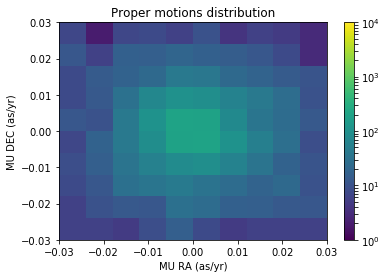

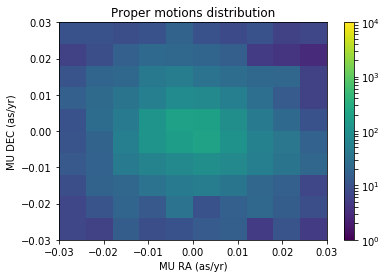

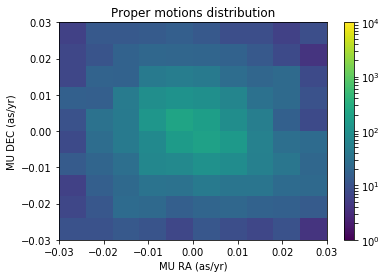

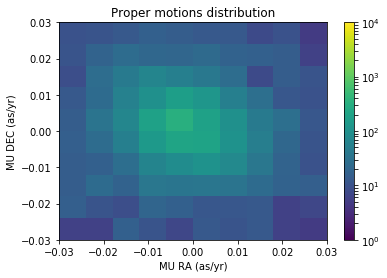

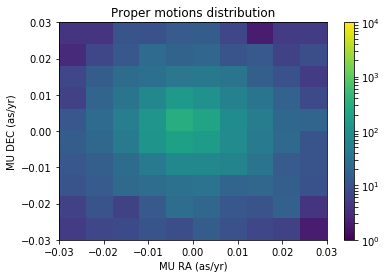

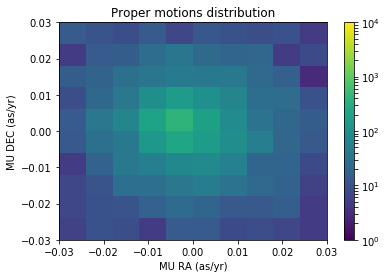

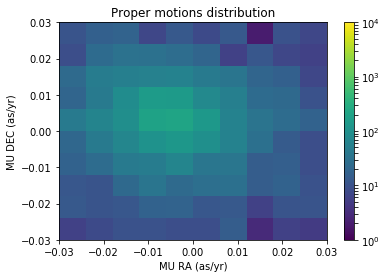

In [103]:
for tile in tiles:
    PM_density_plots(tile, lim = 0.03)

In [93]:
(np.where(tiles[1]['VEL'] > 1000))

(array([8549, 9000, 9081]),)

In [9]:
tiles[1][8549]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8988.0,233067889.0,0.00353643018752,0.00422763405368,5.01187162043,23.8840272333,6764176.66383,-3.89816665649,6750559.3793,403.701131417,2232487.93766,2824.50630516,2227993.74079,-200.979926674,3885993.15582,-609.340496688,-350.044570586,-349.874346892,3878170.19234,23.688778,-5.2638,3.0,3.65381985122,2852.97017095,1492.65766228


In [7]:
def Pos_density_plots(tile):
    ''' 2D histogram of sources in tile by position '''
    ra = []
    dec = []
    for row in tile:
        if row['SPREAD_MODEL'] < 0.004:
            ra.append(row['RA'])
            dec.append(row['DEC'])
    plt.hist2d(ra, dec, 30)
    #plt.xlim(-2, 2)
    #plt.ylim(-2, 2)
    plt.title('Positions distribution')
    plt.xlabel('RA (deg)')
    plt.ylabel('DEC (deg)')
    plt.colorbar()
    plt.show()

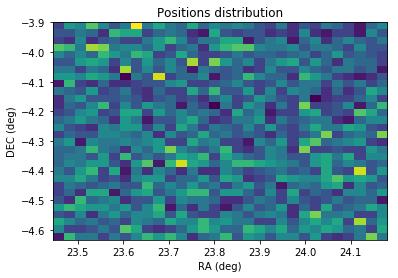

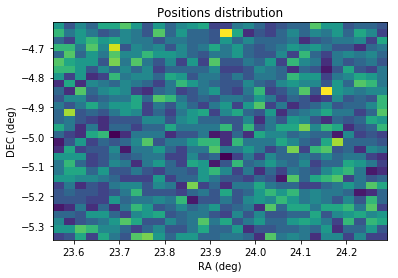

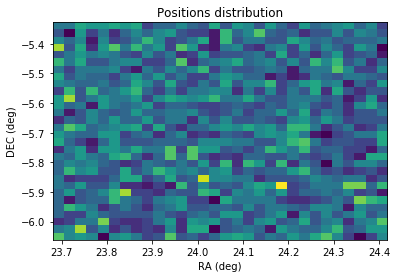

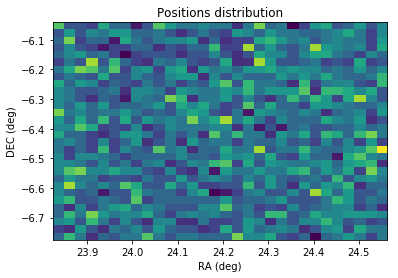

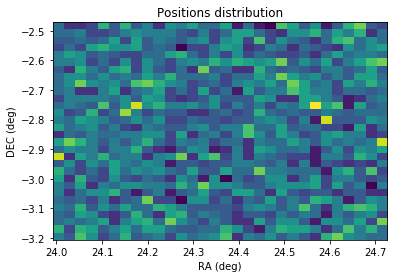

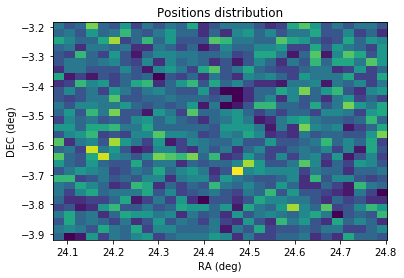

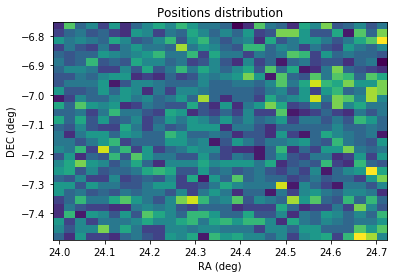

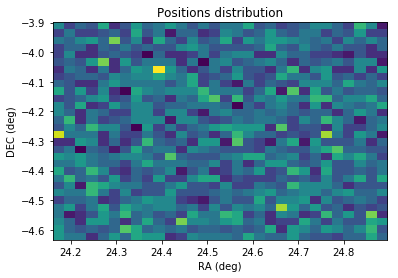

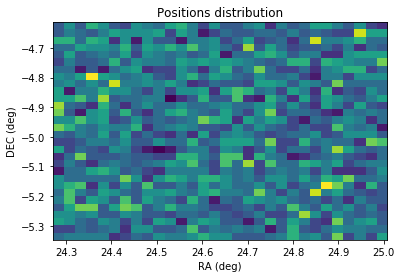

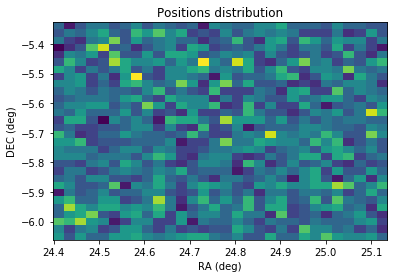

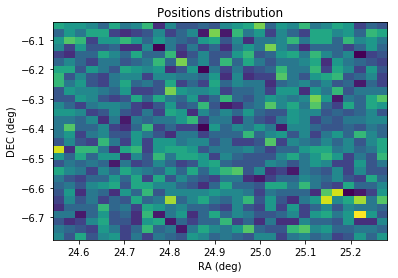

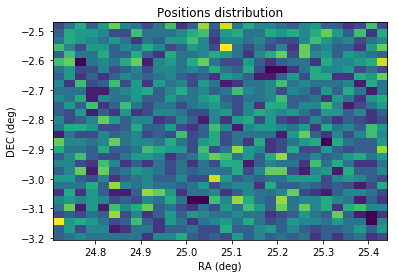

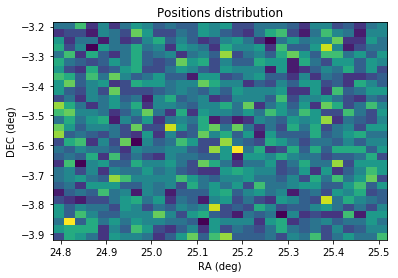

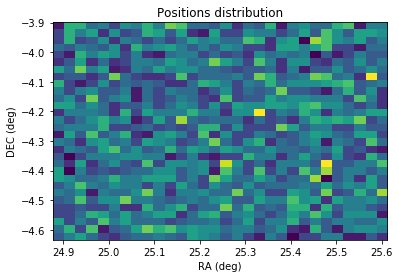

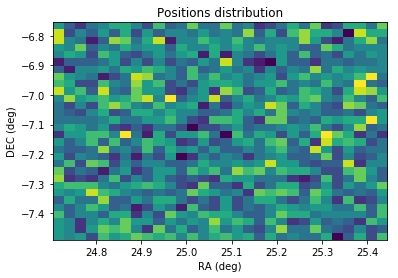

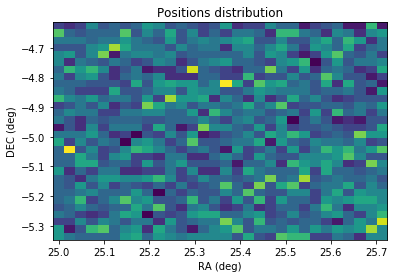

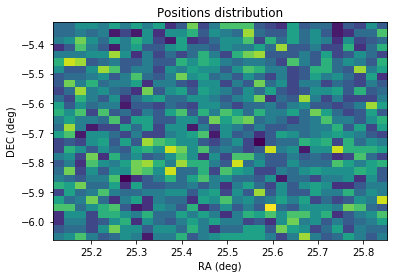

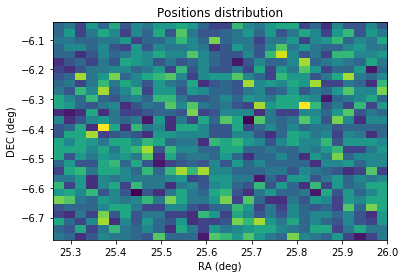

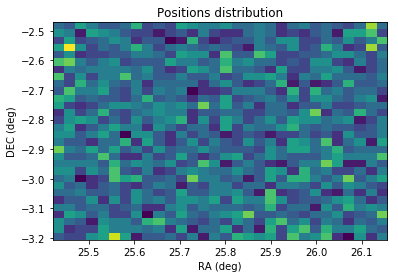

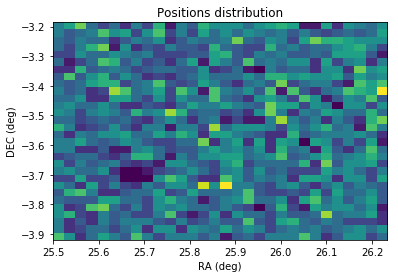

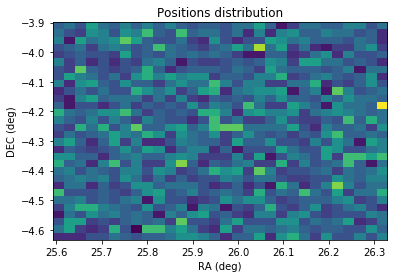

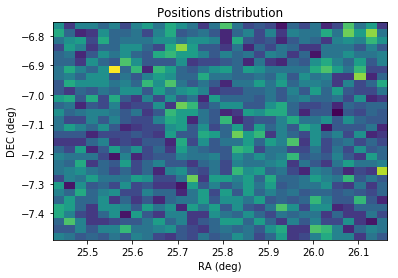

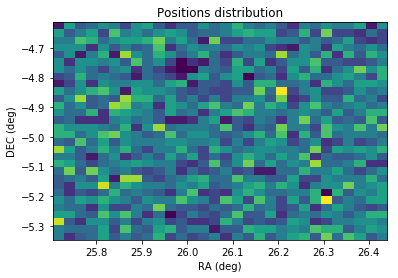

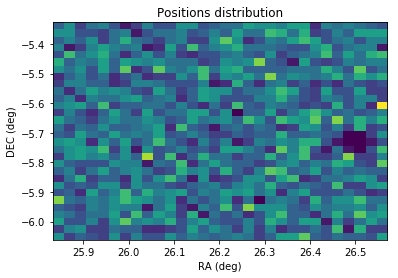

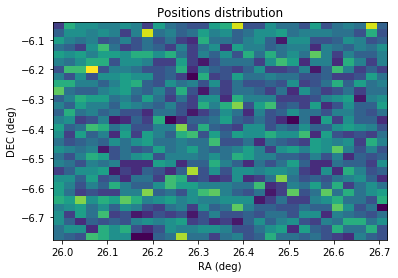

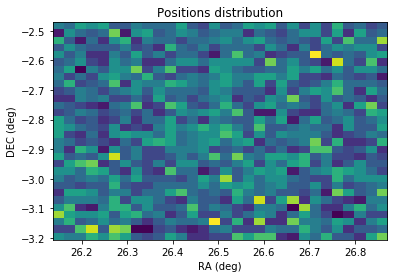

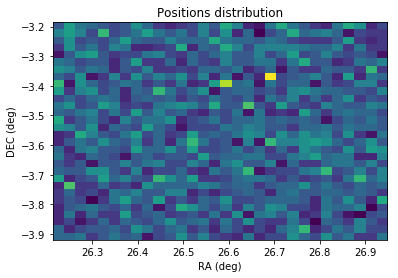

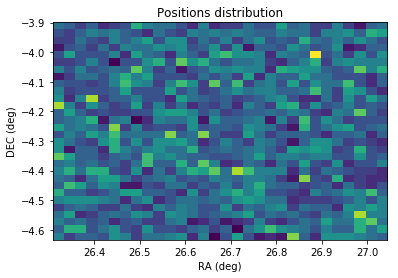

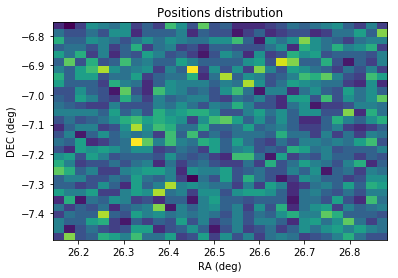

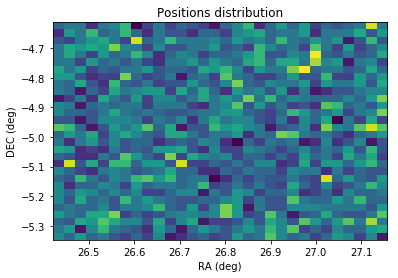

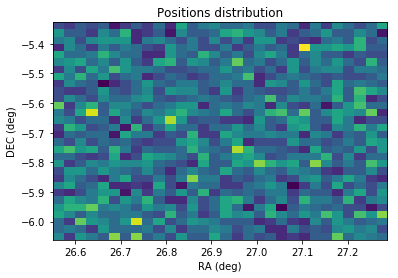

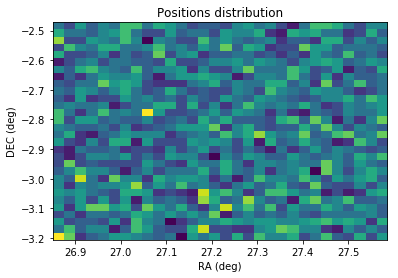

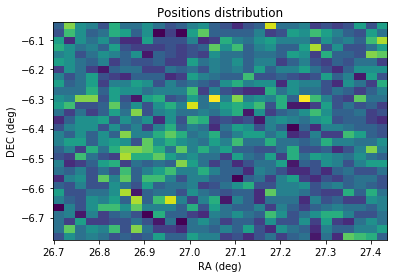

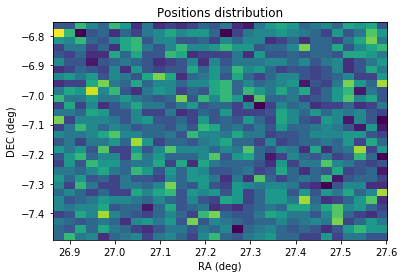

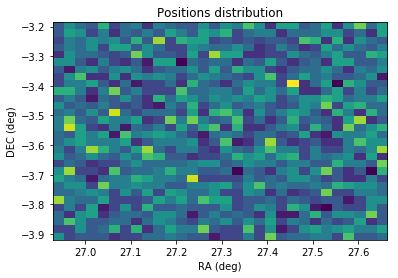

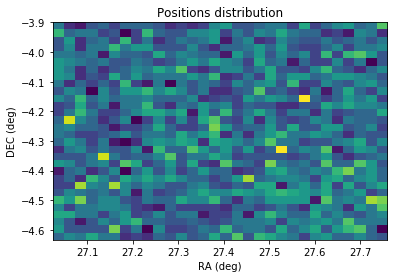

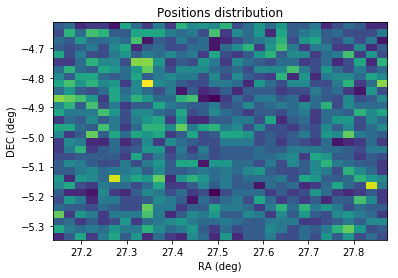

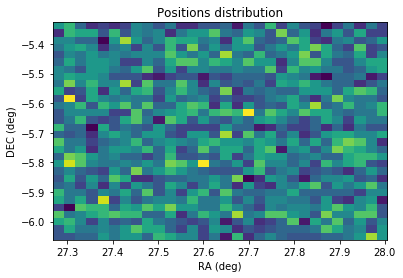

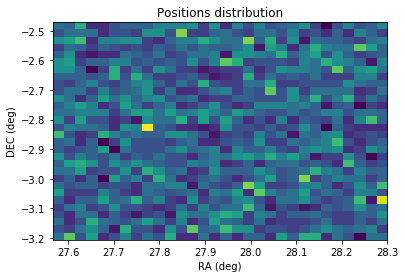

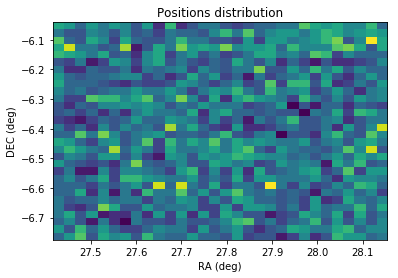

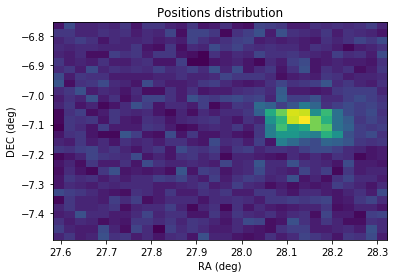

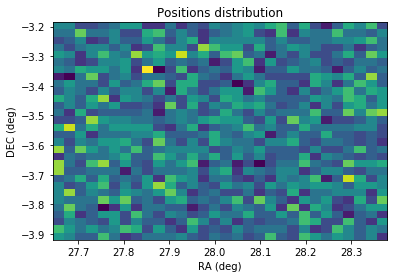

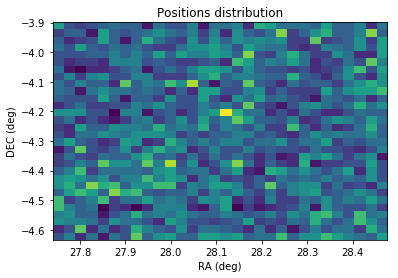

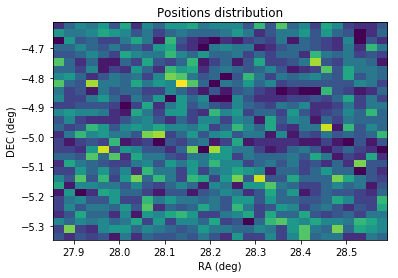

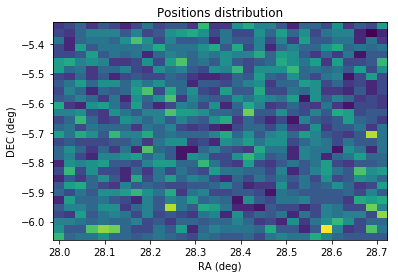

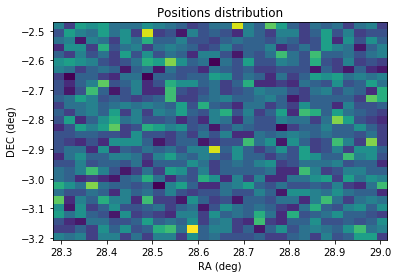

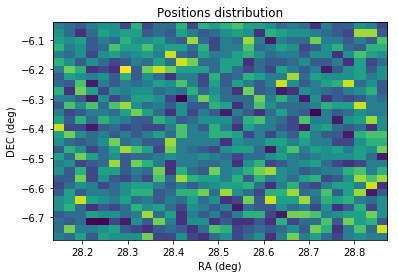

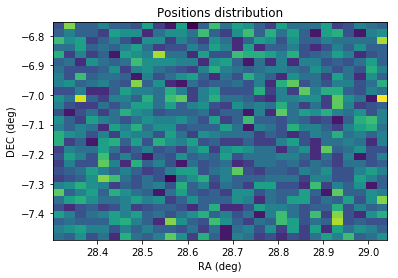

In [13]:
for tile in tiles:
    Pos_density_plots(tile)

In [22]:
con1 = set(np.where(tiles[40]['RA'] > 28)[0])
con2 = set(np.where(tiles[40]['RA'] < 28.3)[0])
con3 = set(np.where(tiles[40]['DEC'] > -7.2)[0])
con4 = set(np.where(tiles[40]['DEC'] < -7)[0])

In [23]:
#overdensity?
od = list(con1.intersection(con2, con3, con4))

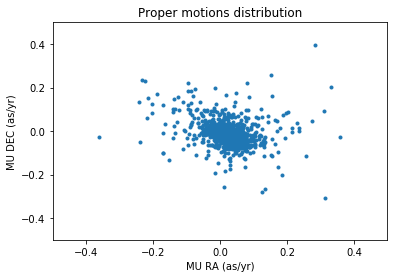

In [24]:
PM_density_plots(tiles[40][od])

In [39]:
temp = tiles[40][od][np.where(tiles[40][od]['N'] > 10)]
temp2 = temp[np.where(temp['CHI2_RED'] < 2)]
temp2[np.where(temp2['CHI_NULL'] > 80)]

MATCH_ID,COADD_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,CHI_NULL,VEL,SIGMA_VEL
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
11013.0,257768236.0,0.0,0.0,1.87706040506,28.0824269065,3.61225800599e-05,-7.11206556278,3.62243681403e-05,0.043927034977,2.79631006585e-05,-0.0245855658915,2.76408754975e-05,-6.10909432509e-07,3.71888476706e-06,-1.7667727049e-07,4.27255066928e-07,4.27042246627e-07,4.1183315615e-06,28.082376,-7.112024,27.0,89.2085280261,0.0500445416297,0.00532992967669
3385.0,257762388.0,-0.00306655163877,5.41619046999e-05,1.91366374165,28.2282941348,2.52802790691e-06,-7.00991341209,3.78144882668e-06,0.0228881482604,2.63131083691e-06,0.00443062676042,2.3625134831e-06,1.47159558015e-07,6.65936889181e-07,5.91959341213e-08,-7.20612196167e-08,-1.03145108674e-07,1.9353218766e-06,28.228241,-7.009887,16.0,203.306070843,0.0231450934405,0.00163608064931
17572.0,257765975.0,0.0197028722614,0.00243465323001,1.94359870604,28.2860996404,0.000164467753083,-7.07209472371,0.000164612690038,0.101254259544,0.000125377160251,-0.0154573620813,0.000125160224753,-8.90112930127e-07,1.26059941008e-05,-3.96326578728e-07,5.03980259679e-07,5.0315115667e-07,1.30897339557e-05,28.286066,-7.072084,20.0,83.5083216334,0.101665866936,0.0112089101062


In [35]:
filenames[40]

'zone029/DES0151-0707_proper_n.fits'

In [36]:
# 
def ImageQuery(match_id, final):
    ''' function to write sql query '''
    trunc = final[np.where(final['MATCH_ID'] == match_id)]
    trunc2 = trunc[np.where(trunc['VERSION'] != 'COADD')]
    ccdnum = []
    expnum = []
    for iden in trunc2:
        ccdnum.append(iden['CCDNUM'])
        expnum.append(iden['EXPNUM'])
    pre = "select 'https://desar2.cosmology.illinois.edu/DESFiles/desarchive/' || a.path || '/' || a.filename || a.compression as url  from y4a1_file_archive_info a inner join y4a1_image i on i.filename=a.filename where "
    post = "and filetype='red_immask'; > exposures.csv"
    qry = "("
    for i in range(len(trunc2)):
        seg = "(expnum={0} and ccdnum={1})".format(expnum[i],ccdnum[i])
        qry += seg
        if i != len(trunc2) - 1:
            qry += " or "
        else:
            qry += ") "
    print(pre + qry + post)
    

In [78]:
fin2 = tb.Table.read('DES0151-0707_final.fits')

In [41]:
ImageQuery(17572, fin2)

select 'https://desar2.cosmology.illinois.edu/DESFiles/desarchive/' || a.path || '/' || a.filename || a.compression as url  from y4a1_file_archive_info a inner join y4a1_image i on i.filename=a.filename where ((expnum=400373 and ccdnum=21) or (expnum=574708 and ccdnum=1) or (expnum=584979 and ccdnum=38) or (expnum=241161 and ccdnum=49) or (expnum=241160 and ccdnum=49) or (expnum=584980 and ccdnum=38) or (expnum=243594 and ccdnum=49) or (expnum=494945 and ccdnum=30) or (expnum=493175 and ccdnum=30) or (expnum=585298 and ccdnum=38) or (expnum=390910 and ccdnum=17) or (expnum=374557 and ccdnum=17) or (expnum=387089 and ccdnum=21) or (expnum=580341 and ccdnum=27) or (expnum=584976 and ccdnum=1) or (expnum=585300 and ccdnum=1) or (expnum=362061 and ccdnum=17) or (expnum=580342 and ccdnum=27) or (expnum=493176 and ccdnum=30) or (expnum=378179 and ccdnum=21)) and filetype='red_immask'; > exposures.csv


In [24]:
def PM_hist_plots(tile,xmin = 0,xmax = 0,ymin = 0,ymax = 0,lim = 0.05):
    ''' Makes a corner plot (contour) for proper motions distribution '''
    pmra = []
    pmdec = []
    for row in tile:
        if row['SPREAD_MODEL'] < 0.004:
            pmra.append(row['MU_RA'])
            pmdec.append(row['MU_DEC'])
    #pmra, pmdec = gaussian_filter((pmra, pmdec), (1, 1))
    #plt.plot(pmra, pmdec, '.', alpha = 0.5)
    #plt.hist(pmra,range=[-lim, lim])
    if xmin != 0:
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
    #else:
        #plt.xlim(-lim, lim)
        #plt.ylim(-lim, lim)
    #plt.title('Proper motions distribution')
    #plt.xlabel('MU RA (as/yr)')
    #plt.ylabel('#')
    #plt.show()
    ndim, nsamples = 2, len(pmra)
    #samples = np.random.randn(ndim * nsamples).reshape([nsamples, ndim])
    samples = np.array(list(zip(pmra, pmdec))).reshape(nsamples, ndim)
    figure = corner.corner(samples, range=[(-0.05, 0.05), (-0.05,0.05)], quantiles = [0.25,0.5,0.75], labels = ["MU RA (as/yr)", "MU DEC (as/yr)"], show_titles = True)
    #
    #plt.hist(pmdec,range=[-lim, lim])
    #plt.title('Proper motions distribution')
    #plt.xlabel('MU RA (as/yr)')
    #plt.ylabel('MU DEC (as/yr)')
    plt.show()
    # corner plot

In [5]:
gal1 = tb.Table.read('DES0343-4331_proper_n.fits')
cut = np.where((gal1['RA'] > 56.03) & (gal1['RA']  < 56.15) & (gal1['DEC'] >-43.56) & (gal1['DEC']<-43.5))

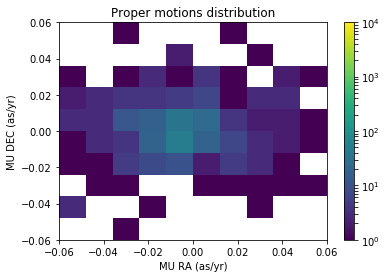

In [124]:
PM_density_plots(gal1[cut], lim=0.06)

In [26]:
noncut = np.where((gal1['RA'] > 55.4) & (gal1['RA']  < 55.6) & (gal1['DEC'] >-43.5) & (gal1['DEC']<-43.4))
PM_density_plots(gal1[noncut], lim=0.06)

NameError: name 'PM_density_plots' is not defined

In [27]:
noncut2 = np.where((gal1['RA'] > 55.4) & (gal1['RA']  < 55.6) & (gal1['DEC'] >-43.8) & (gal1['DEC']<-43.7))
noncut3 = np.where((gal1['RA'] > 55.8) & (gal1['RA']  < 56) & (gal1['DEC'] >-43.8) & (gal1['DEC']<-43.7))
noncut4 = np.where((gal1['RA'] > 55.6) & (gal1['RA']  < 55.8) & (gal1['DEC'] >-43.4) & (gal1['DEC']<-43.2))

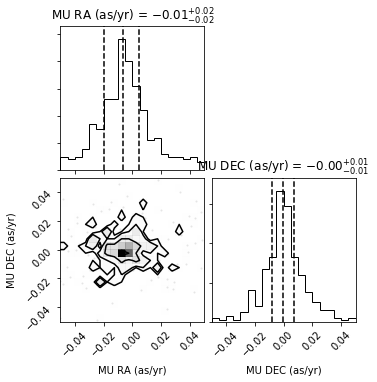

In [25]:
PM_hist_plots(gal1[cut])

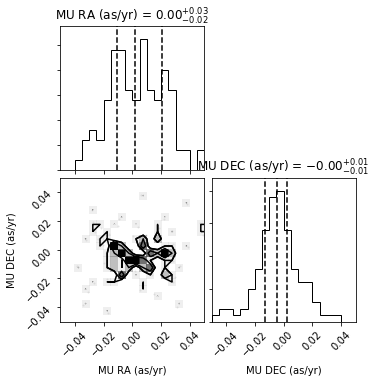

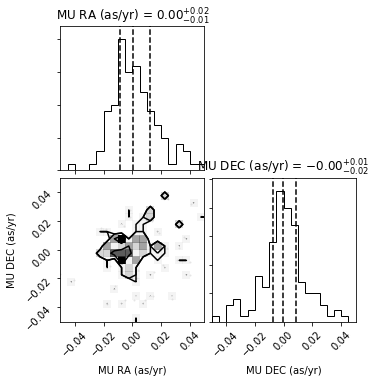

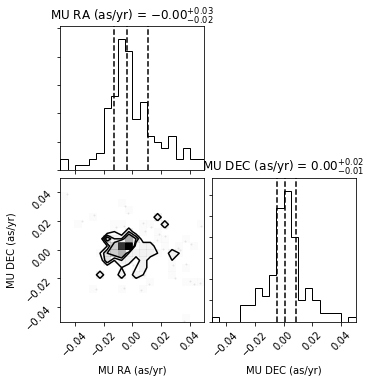

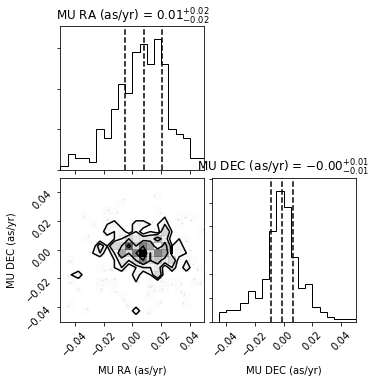

In [28]:
PM_hist_plots(gal1[noncut])
PM_hist_plots(gal1[noncut2])
PM_hist_plots(gal1[noncut3])
PM_hist_plots(gal1[noncut4])

In [29]:
noncut5 = np.where((gal1['RA'] > 55.4) & (gal1['RA']  < 55.8) & (gal1['DEC'] >-43.8) & (gal1['DEC']<-43.2))
cut_p = np.where((gal1['RA'] > 55.9) & (gal1['RA']  < 56.2) & (gal1['DEC'] >-43.7) & (gal1['DEC']<-43.3))

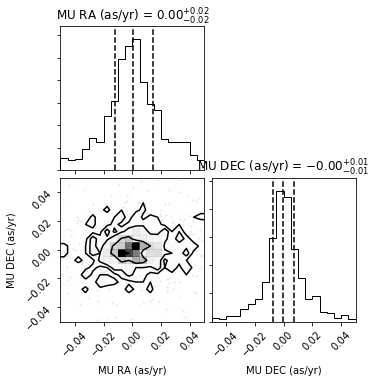

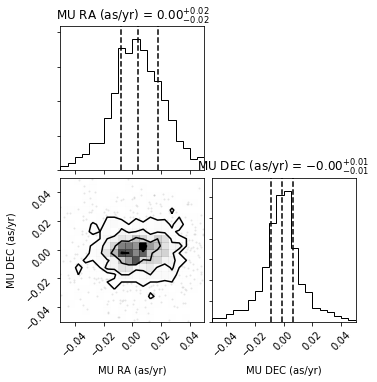

In [30]:
PM_hist_plots(gal1[cut_p])
PM_hist_plots(gal1[noncut5])

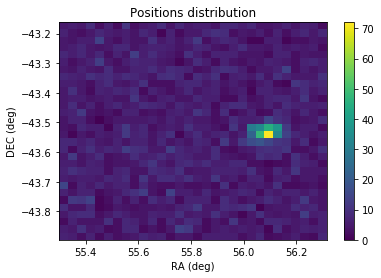

In [8]:
Pos_density_plots(gal1)

In [9]:
gal2 = tb.Table.read('DES0337-5414_proper_n.fits')
cut2 = np.where((gal2['RA'] > 53.8) & (gal2['RA']  < 54.1) & (gal2['DEC'] >-54.11) & (gal2['DEC']<-54))

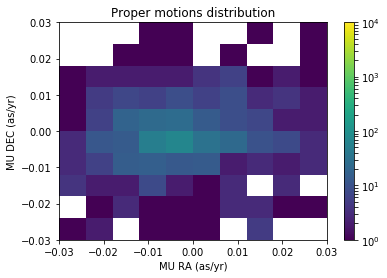

In [114]:
PM_density_plots(gal2[cut2], lim=0.03)

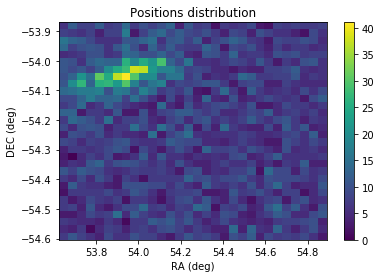

In [10]:
Pos_density_plots(gal2)

## Color-Mag plot

In [114]:
def color_mag(tile, final):
    for row in tile:
        coadd = final[np.where((final['MATCH_ID'] == row['MATCH_ID']) & (final['VERSION'] == 'COADD'))]
        g_mag = coadd['MAG_AUTO_G']
        r_mag = coadd['MAG_AUTO_R']
        if len(g_mag) == 1:
            if (g_mag < 35):
                plt.plot(g_mag - r_mag, g_mag,'g.', alpha = 0.7)
    plt.ylim(30, 17)
    plt.xlim(-5, 6) # -5, 6
    plt.xlabel('G - R')
    plt.ylabel('G Magnitude')
    plt.show()

In [82]:
z147 = tb.Table.read('DES0343-4331_final.fits')

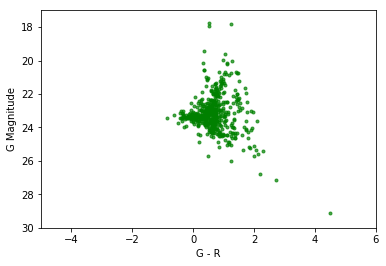

In [115]:
color_mag(gal1[cut], z147)

In [83]:
z186 = tb.Table.read('DES0337-5414_final.fits')

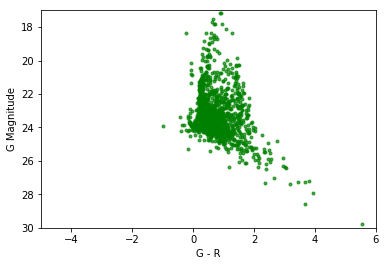

In [116]:
color_mag(gal2[cut2], z186)

In [112]:
from isochrones.mist import MIST_Isochrone

In [111]:
mist = MIST_Isochrone('g','r')

In [112]:
mist.mag['g']([1,4], 4, -4)

/Users/Suyog/anaconda/lib/python3.6/site-packages/isochrones/mist/grid.py:195: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = super(MISTModelGrid, self).df_all(phot)
/Users/Suyog/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['[Fe/H]']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


array([ nan,  nan])

In [117]:
from scipy.ndimage.filters import gaussian_filter

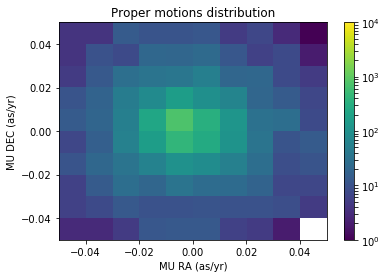

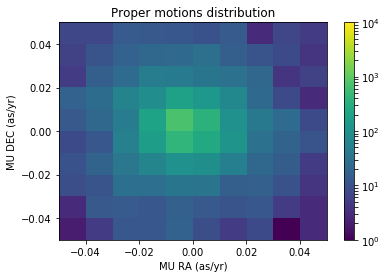

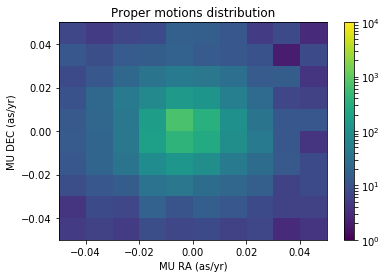

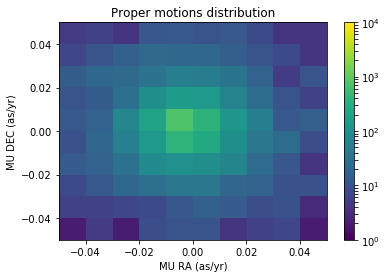

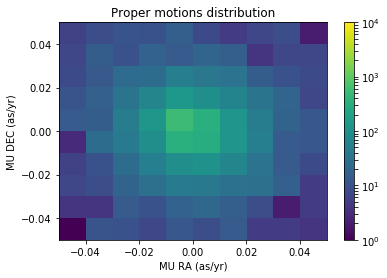

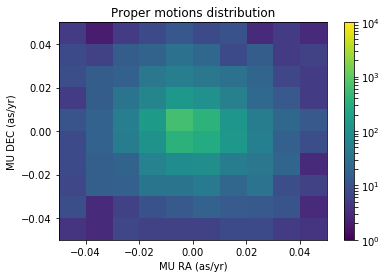

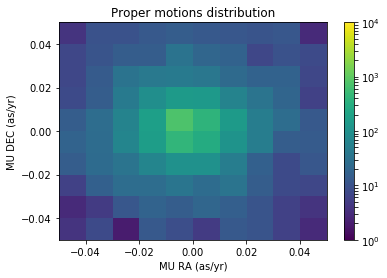

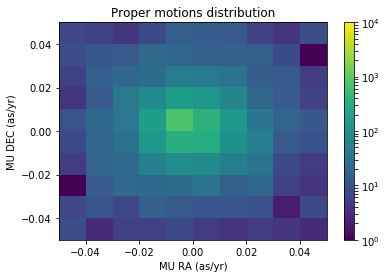

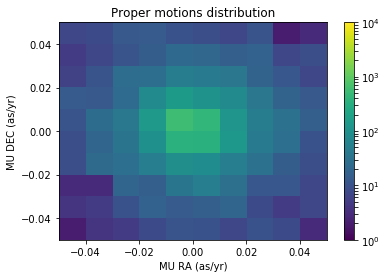

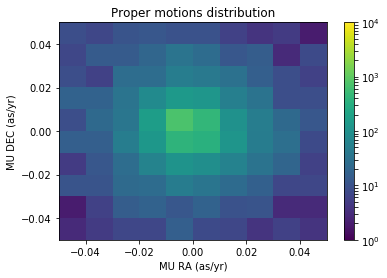

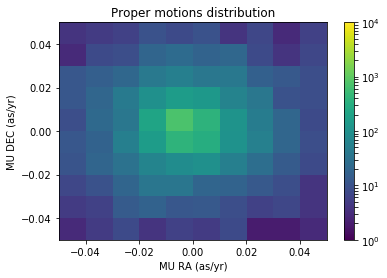

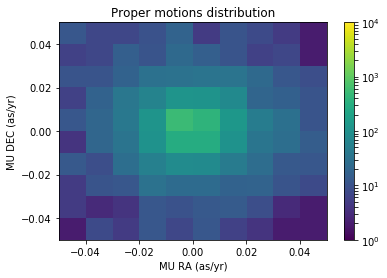

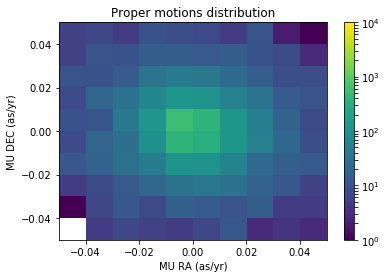

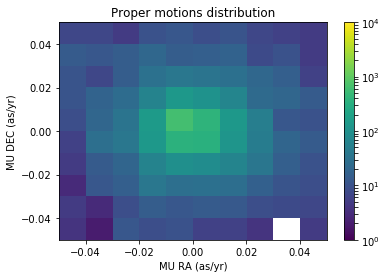

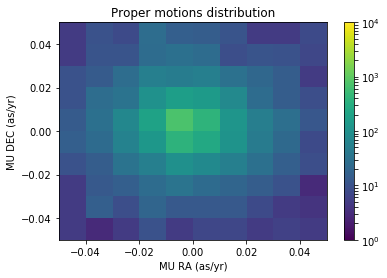

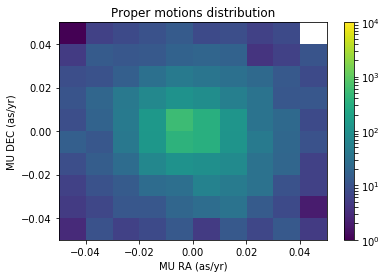

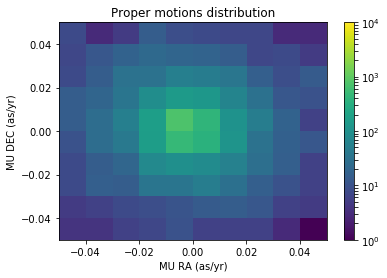

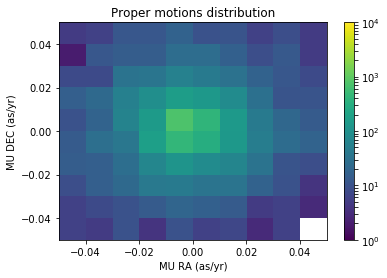

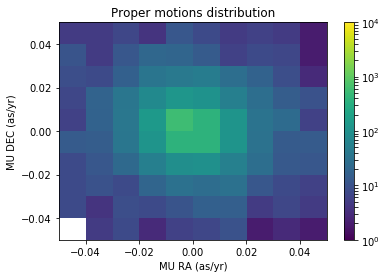

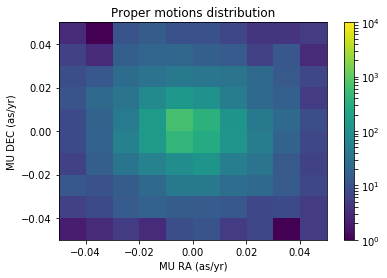

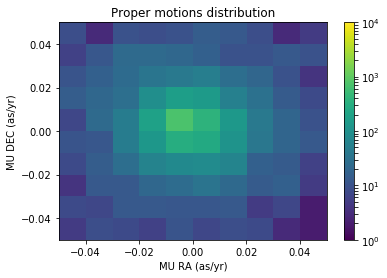

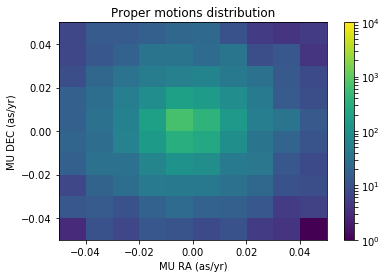

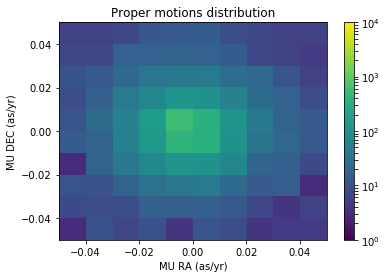

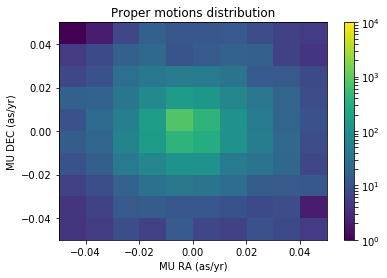

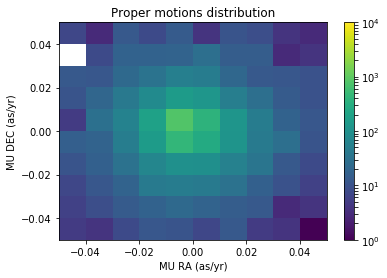

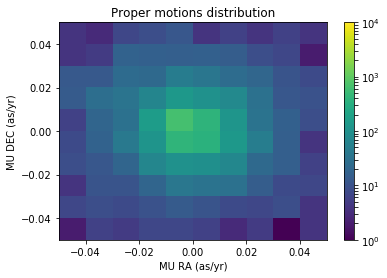

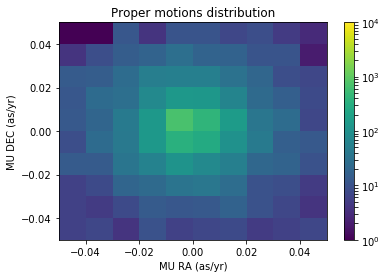

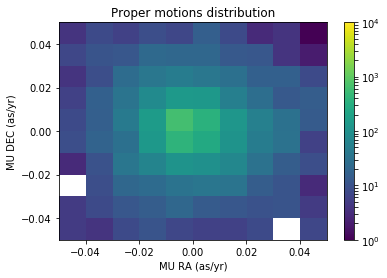

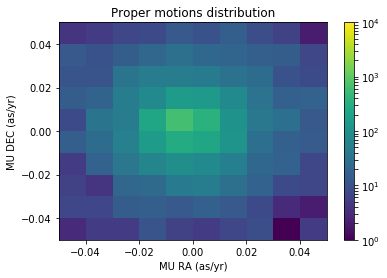

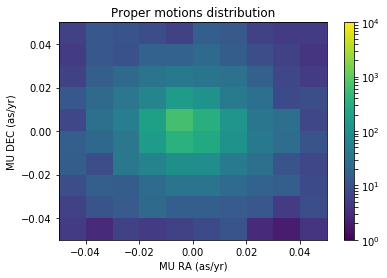

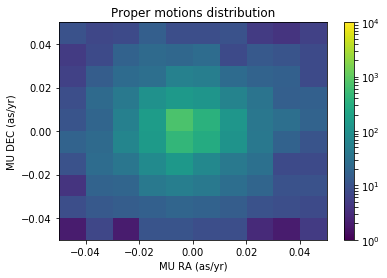

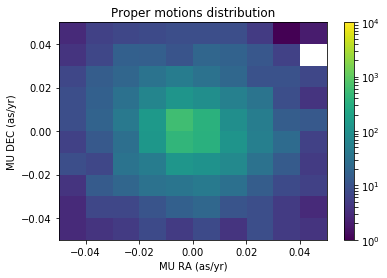

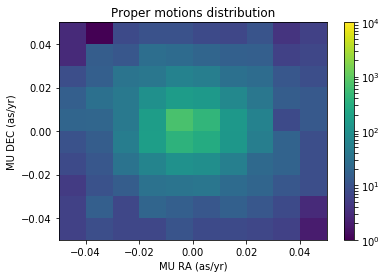

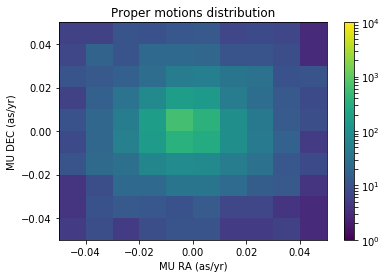

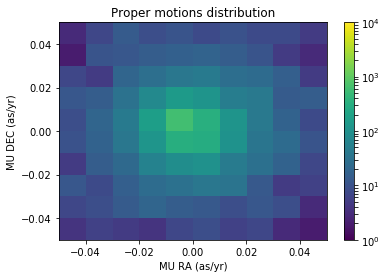

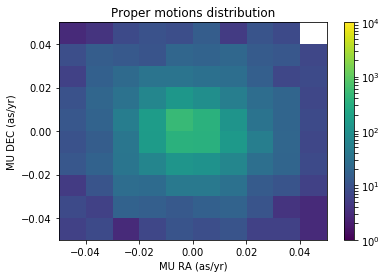

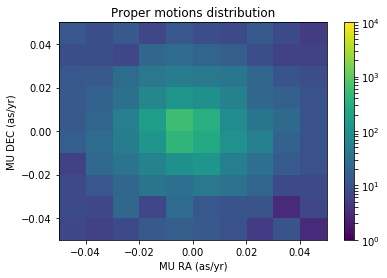

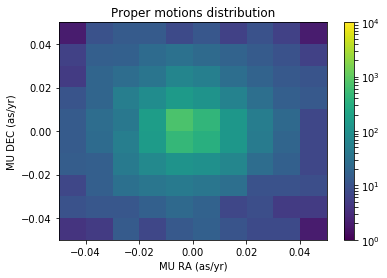

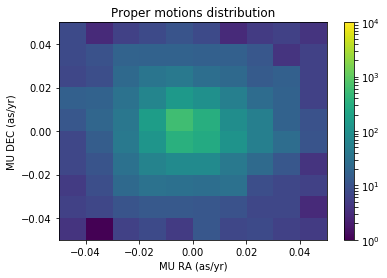

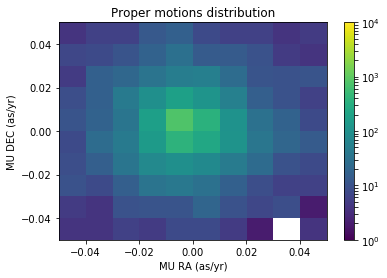

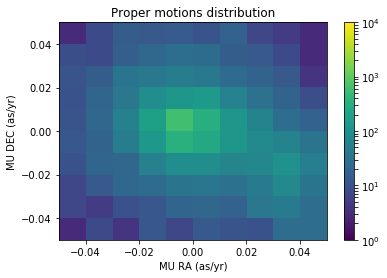

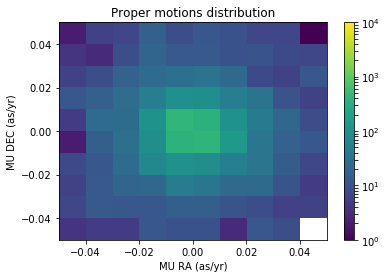

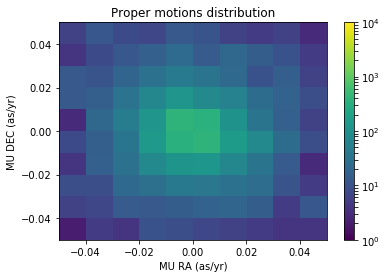

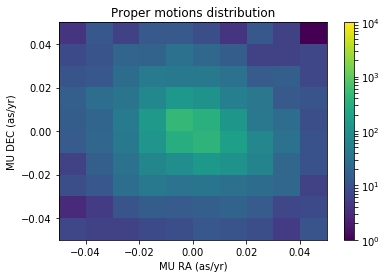

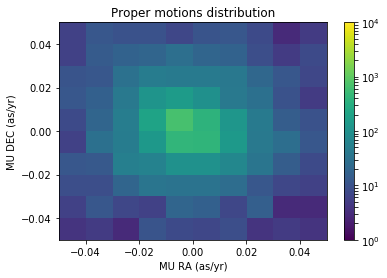

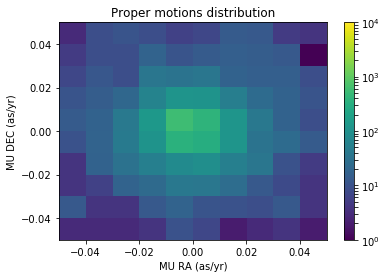

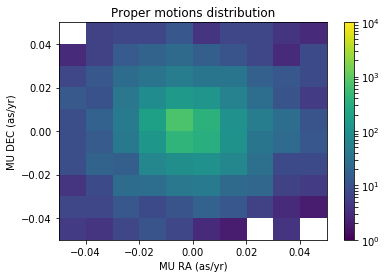

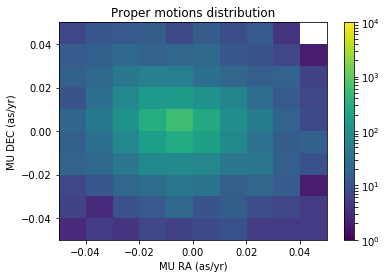

In [113]:
for tile in tiles:
    PM_density_plots(tile)

In [100]:
def Inv_var_weighting(fin):
    """ Takes in a _final.fits table as input and returns a table of COADDS with additional
    column SPREAD_MODEL_WEIGHTED AVG"""
    col = tb.Column(data =[0.0]*len(fin), name = 'SPREAD_MODEL_WEIGHTED_AVG')
    fin['SPREAD_MODEL_WEIGHTED_AVG'] = col
    coadds = fin[np.where(fin['VERSION'] == 'COADD')]
    for i, row in enumerate(coadds):
        m_id = row['MATCH_ID']
        obs = fin[np.where((fin['MATCH_ID'] == m_id) & (fin['VERSION'] != 'COADD'))]
        if len(obs) != 0:
            num = np.sum([i for i in np.array(obs['SPREAD_MODEL'])/np.array(obs['SPREADERR_MODEL']**2)])
            den = np.sum([i for i in 1/np.array(obs['SPREADERR_MODEL']**2)])
            if not np.isnan(num/den):
                coadds['SPREAD_MODEL_WEIGHTED_AVG'][i] = num/den
    return coadds

In [99]:
cod = Inv_var_weighting(fin)

In [96]:
cod['SPREAD_MODEL_I', 'SPREAD_MODEL_WEIGHTED_AVG']

SPREAD_MODEL_I,SPREAD_MODEL_WEIGHTED_AVG
float64,float64
0.00665117893368,0.0100237798145
-0.0042734220624,-6.23330983651e-05
0.0106297908351,0.0136751018248
0.00328959245235,0.00573392009698
-0.00321618909948,-0.00101181405466
-0.00245652813464,-0.000142412248896
-0.00123213988263,-0.000190913005587
0.028303604573,0.0307349473263
0.0170058254153,0.0146573984754


In [66]:
#tst = tb.Table.read('zone029/DES0135-0416_proper_n.fits')

In [67]:
#tst

In [63]:
def spread_model_bymag(tile):
    ''' buckets spread model values by g-magnitude classification '''
    for row in tile:
        g_mag = row['MAG_AUTO_G']
        mags.append(g_mag)
        spread_mod.append(row['SPREAD_MODEL_WAVG'])

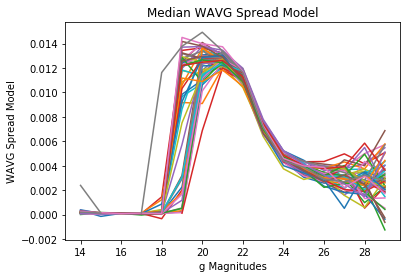

In [65]:
for tile in tiles:
    mags = []
    spread_mod = []
    sm_med = []
    spread_model_bymag(tile)
    ranges = list(range(14,31))
    for i in range(16):
        idx = [j for j,v in enumerate(mags) if ((mags[j] > ranges[i]) & (mags[j] < ranges[i+1]))]
        if len(idx) != 0:
            m = median(np.array(spread_mod)[idx])
            sm_med.append(m)
        else:
            sm_med.append(-10)
    plt.plot(ranges[0:16], sm_med, label = 'DES')
plt.title('Median WAVG Spread Model')
plt.xlabel('g Magnitudes')
plt.ylabel('WAVG Spread Model')
plt.show()

In [74]:
tiles2[0]

MATCH_ID,COADD_OBJECT_ID,SPREAD_MODEL,SPREADERR_MODEL,CHI2_RED,RA_0,RA_ERR,DEC_0,DEC_ERR,MU_RA,MU_RA_ERR,MU_DEC,MU_DEC_ERR,COV_MU_RA_MU_DEC,COV_RA_MU_RA,COV_RA_DEC,COV_RA_MU_DEC,COV_DEC_MU_RA,COV_DEC_MU_DEC,RA,DEC,N,SPREAD_MODEL_WAVG,DELTA_T,CHI_NULL,VEL,SIGMA_VEL,MAG_AUTO_G,MAG_AUTO_R,MAG_AUTO_I,MAG_AUTO_Z,MAG_AUTO_Y
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,343958472.0,0.0112287057564,0.000409112108173,1.10984844063,46.0946442602,2.14050858432e-05,-17.6428700408,1.94691411821e-05,-0.0190864075502,2.62508592193e-05,-0.000167365306433,2.41766497004e-05,5.40307933437e-09,-1.28833781822e-05,1.62269251696e-07,1.19778528329e-08,1.55603441054e-08,-1.2199571193e-05,46.094605,-17.642846,21.0,0.0108393624167,865.65862194,13.8784012145,0.0181894347809,0.00512355179898,22.4614048004,20.8589038849,20.0629310608,19.6778411865,19.5783901215
1.0,343958412.0,0.0124113271013,0.000638639146928,1.42094794562,46.0702258528,5.56481084415e-05,-17.6418183352,5.33948396767e-05,-0.0236176527816,6.72757609842e-05,-0.009969193959,6.48625949725e-05,1.44721553441e-07,-3.38115336029e-05,2.55513934758e-07,-6.80505616391e-08,-6.65508762689e-08,-3.30168183424e-05,46.070183,-17.641799,20.0,0.0114949098615,865.65862194,9.80781756752,0.0246159673168,0.00818456724646,22.5135803223,21.0027885437,20.4228801727,20.1528091431,20.0191612244
2.0,343958104.0,0.0155579801649,0.000593542994466,1.31758334619,46.0706876607,5.88556072482e-05,-17.6374540001,5.70243626507e-05,-0.0130087204027,6.47340416451e-05,-0.00419694567238,6.32703448834e-05,-8.09616894324e-08,-3.21832889377e-05,2.94366936493e-07,-2.45263552647e-07,-2.43459767006e-07,-3.12730560201e-05,46.070649,-17.63743,29.0,0.0169065321344,865.65862194,2.8947470489,0.0130883682074,0.00803332790392,22.0051460266,20.7354068756,20.179977417,19.870475769,19.5107707977
3.0,343958491.0,-0.000145258454722,0.000328589609126,1.51485591911,46.0462357145,1.47450317089e-05,-17.6425534114,1.18353191474e-05,-0.00582505146027,1.72880086956e-05,-0.0167393611668,1.48968561908e-05,2.32669785368e-07,-1.00282956674e-05,6.52174955764e-07,-3.39066192535e-07,-3.28872976395e-07,-8.42536260705e-06,46.046196,-17.642531,20.0,-1.97801886085e-05,865.65862194,20.600602967,0.017635777668,0.00390804124969,23.2357635498,21.7098503113,20.2824668884,19.6402301788,19.5209693909
4.0,343958208.0,0.000667351880111,0.000768247060478,1.39692870882,46.0511682744,3.53866257604e-05,-17.6365459673,3.32995695715e-05,-0.0138132378686,3.29635032194e-05,-0.00811361775779,3.10543473603e-05,6.97488824002e-08,-2.26867611705e-05,3.77296993131e-07,-2.69385982995e-07,-2.63873787207e-07,-2.16809920742e-05,46.051132,-17.636521,26.0,3.08941367498e-06,1160.8318668,7.89300999032,0.0154635468212,0.00570089607046,22.5426273346,21.6998996735,21.3688259125,21.1452140808,21.1647148132
5.0,343957669.0,0.000269018812105,0.000316035730066,1.23222785731,46.0902121574,6.80767007718e-06,-17.6265082564,5.65338223295e-06,-0.000490996726131,7.77746496622e-06,0.00275871767101,6.76756221453e-06,-1.46782924927e-07,-2.98306055272e-06,-3.21723459586e-09,2.60078219375e-08,2.58493685585e-08,-2.52407492033e-06,46.090176,-17.626483,34.0,-7.03754076138e-06,1160.8318668,1.14847133494,0.00279812357628,0.00261614409866,22.7173118591,21.3638725281,20.351776123,19.9800510406,19.8756866455
6.0,343957456.0,-0.000194323933101,0.000256912171608,2.46970485239,46.0903404486,3.8986328665e-06,-17.6222533122,2.91171846877e-06,0.00422431042046,4.52996752028e-06,-0.00415762947009,3.48436791824e-06,8.55578671141e-08,-1.49230413476e-06,2.26939770654e-07,-2.10148100093e-07,-1.99950403518e-07,-1.21766684166e-06,46.090307,-17.622231,34.0,-8.97997448465e-05,1160.8318668,9.0948786329,0.00578750220608,0.00197606946024,21.0777225494,20.3984737396,20.1421165466,19.9870414734,19.9924316406
7.0,343957244.0,7.786958

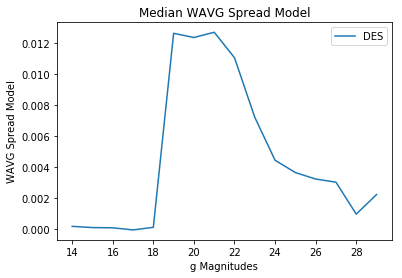

In [62]:
plt.plot(ranges[0:16], sm_med, label = 'DES')
#plt.ylim(0, 0.030)
plt.legend()
plt.title('Median WAVG Spread Model')
plt.xlabel('g Magnitudes')
plt.ylabel('WAVG Spread Model')
plt.show()

In [72]:
tiles2[0]
np.cos(-17.5*np.pi/180)

0.95371695074822693